<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.975 · Deep Learning · PEC4</p>
<p style="margin: 0; text-align:right;">2022-2 · Master universitario en Ciencia de datos (Data science)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudios de Informatica, Multimedia y Telecomunicaciones</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>


# PEC 4: Modelos generativos

En esta práctica implementaremos uno de los tipos de modelos generativos más utilizados actualmente, las redes generativas adversarias, ie. **GANs**.

<u>Consideraciones generales</u>:

- Esta PEC debe realizarse de manera **estrictamente individual**. Cualquier indicio de copia será penalizado con un suspenso (D) para todas las partes implicadas y la posible evaluación negativa de la asignatura de forma íntegra.
- Es necesario que el estudiante indique **todas las fuentes** que ha utilizado para la realización de la PEC. Si no es así, se considerará que el estudiante ha cometido plagio, siendo penalizado con un suspenso (D) y la posible evaluación negativa de la asignatura de forma íntegra.

<u>Formato de entrega</u>:

- Algunos ejercicios pueden suponer varios minutos de ejecución, por lo que la entrega debe realizarse en **formato notebook** y en **formato html**, donde se vea el código, los resultados y comentarios de cada ejercicio. Se puede exportar el notebook a HTML desde el menú File $\to$ Download as $\to$ HTML.
- Existe un tipo de celda especial para albergar texto. Este tipo de celda le será muy útil para responder a las diferentes preguntas teóricas planteadas a lo largo de la actividad. Puede cambiar el tipo de celda a este tipo, en el menú: Cell $\to$ Cell Type $\to$ Markdown.

# 0. Introducción

El objetivo de esta PEC es comprender la implementación de una solución generativa, utilizando DCGANs para la generación de imágenes, mediante el conjunto de datos de referencia en deep learning más sencillo existente: MNIST.



In [1]:
import numpy as np
import time
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Reshape
from keras.layers import Conv2D, Conv2DTranspose, UpSampling2D
from keras.layers import LeakyReLU, Dropout
from keras.layers import BatchNormalization
from keras.optimizers import Adam, RMSprop
from matplotlib import pyplot as plt

# 1. Obtención de los datos

El código para cargar los datos es el siguiente:

In [7]:
latent_dim = 100

img_rows, img_cols = 28, 28
img_channels = 1
(x_train, _), (_, _) = mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, img_channels)
x_train = x_train.astype('float32')
x_train /= 255

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<p><strong>Ejercicio [1,5 pts.]:</strong>
Añade un comentario explicativo, a cada una de las líneas de código de abajo, indicando cuál es su funcionalidad.</div>

**Respuesta**:

* `latent_dim = 100`: Establece la dimensión del modelo. Con esta variable podemos indicar al modelo el tamaño que va a recibir de datos. Por ejemplo, en una capa Dense.<br><br>
* `img_rows, img_cols = 28, 28`: Indica la cantidad de filas y columnas para cada imagen. Cada imagen es grayscale y tiene un tamaño de 28x28.<br><br>
* `img_channels = 1`: Representa el número de canales de las imágenes que utiliza el modelo. Cómo tratamos con imágenes en escala de grises, sólo hay 1 canal.<br><br>
* `(x_train, _), (_, _) = mnist.load_data()`: La función load_data() de MNIST carga los valores (x_train, y_train), (x_test, y_test). Dado que no se utilizan los valores y_train, x_test y y_test estos son sustituidos por un guión bajo (_). x_train contiene 60.000 imágenes de tamaño 28x28 en escala de grises para entrenar modelos.<br><br>
* `x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, img_channels)`: Cómo indica el nombre de la función, cambiamos la forma del objeto x_train para que tenga la forma adecuada para el modelo. En este caso, convertimos de un shape de (60000,28,28) a (60000,28,28,1).<br><br>
* `x_train = x_train.astype('float32')`: Establecemos un nuevo tipo para x_train. En este caso, convertimos el valor inicial ('uint8') a ('float32').<br><br>
* `x_train /= 255`: Normalizamos x_train. Hasta este punto los valores oscilaban entre 0 y 255. Al dividirlo por su valor máximo, normalizamos entre 0 y 1 el conjunto de entrenamiento. Esto es una práctica típica para modelos de aprendizaje para proporcionar más estabilidad a los datos.

## 2. Implementación del Generador

A continuación se muestra una propuesta de generador:

In [4]:
def generator_model():
    dropout = 0.4
    depth = 256 # 64+64+64+64
    dim = 7

    model = Sequential()
    # In: 100
    # Out: dim x dim x depth
    model.add(Dense(dim*dim*depth, input_dim=latent_dim))
    model.add(BatchNormalization(momentum=0.9))
    model.add(Activation('relu'))
    model.add(Reshape((dim, dim, depth)))
    model.add(Dropout(dropout))

    # In: dim x dim x depth
    # Out: 2*dim x 2*dim x depth/2
    model.add(UpSampling2D())
    model.add(Conv2DTranspose(int(depth/2), 5, padding='same'))
    model.add(BatchNormalization(momentum=0.9))
    model.add(Activation('relu'))

    model.add(UpSampling2D())
    model.add(Conv2DTranspose(int(depth/4), 5, padding='same'))
    model.add(BatchNormalization(momentum=0.9))
    model.add(Activation('relu'))

    model.add(Conv2DTranspose(int(depth/8), 5, padding='same'))
    model.add(BatchNormalization(momentum=0.9))
    model.add(Activation('relu'))

    # Out: 28 x 28 x 1 grayscale image [0.0,1.0] per pix
    model.add(Conv2DTranspose(1, 5, padding='same'))
    model.add(Activation('sigmoid'))

    return model

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<p><strong>Ejercicio [1,75 pts.]:</strong>
Contesta a las preguntas siguientes:
</div>

**1. ¿Cuál es la finalidad del generador?:**<br><br>
La finalidad del generador es crear un modelo para la generación de imágenes apartir de la entrada de dimension (latent_dim). El generador toma la entrada y utiliza diferentes capas (densas, de convolución, de normalizacion...) y finalmente genera un output de tamaño 28x28 en escala de grises.<br><br>
**2. Investigar por qué se utiliza `Upsampling` en las dos primeras capas en lugar de la `Conv2DTranspose` propuesta en DCGAN. Dar una justificación:**<br><br>
Se utiliza Upsampling en las 2 primeras capas porque se quiere aumentar el tamaño para conseguir una salida de 28x28x1. La primera capa Upsampling convierte la entrada 7x7xN en 14x14xN, mientras que la segunda incrementa la dimensionalidad de 14x14xM a 28x28xM. La estrategia detrás de Upsampling es la duplicación de píxeles (tamaño).<br><br>
**3. ¿Por qué se utiliza la normalización entre capas?**<br><br>
La normalización entre capas se utiliza para proporcionar estabilidad a los datos. Al aplicar normalización, los valores altos o bajos no tienen tanto peso sobre el resultado y el peso se distribuye de manera más igualitaria. Lo que conlleva a un mejor rendimiento del modelo y ayuda a evitar problemas de gradiente y de overfitting. <br><br>
**4. ¿Qué funciones de activación se utilizan? ¿Cuál es la razón de la sigmoide en la última capa?**<br><br>
Se utilizan dos tipos de funciones de activación: relu y sigmoid.<br><br>
La función de activación relu (Rectified Linear Unit) es conocida por proporcionar buenos resultados en multiples problemas de aprendizaje automático. Esta función es no lineal y transforma los valores negativos a cero y mantiene los valores positivos.<br><br>
La activación sigmoid también es una función no lineal y típicamente se utiliza ante la capa de salida. Se utiliza sigmoid para normalizar el resultado entre 0 y 1. En este caso, se utiliza para obtener el resultado en escala de grises con valores de píxeles que oscilan entre 0 y 1.

## 3. Implementación del Discriminador

A continuación se muestra el discriminador propuesto

In [5]:
# (W−F+2P)/S+1
def discriminator_model():
    depth = 64
    dropout = 0.4
    input_shape = (img_rows, img_cols, img_channels)

    model = Sequential()
    # In: 28 x 28 x 1, depth = 1
    # Out: 14 x 14 x 1, depth=64
    model.add(Conv2D(depth, 5, strides=2, input_shape=input_shape, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(dropout))

    model.add(Conv2D(depth*2, 5, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(dropout))

    model.add(Conv2D(depth*4, 5, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(dropout))

    model.add(Conv2D(depth*8, 5, strides=1, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(dropout))

    # Out: 1-dim probability
    model.add(Flatten())
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    return model

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<p><strong>Ejercicio [1,75 pts.]:</strong>
Contesta a las preguntas siguientes:
</div>

**1. ¿Cuál es la finalidad del discriminador?:**<br><br>
La finalidad del discriminador es clasificar datos reales y datos generados artificialmente. En este caso, se trata de clasificar imágenes. En la capa final, podemos observar que la salida es una neurona sigmoid, por lo que el discriminador calsificará de manera binaria (real o falso).<br><br>

**2. ¿Cuáles son las dimensiones de los tensores y características de las variables de entrada y salida del discriminador? :**<br><br>
Las dimensiones de la entrada son (img_rows, img_cols, img_channels). Es decir, la entrada es una imagen de tamaño 28x28x1.<br><br> La variable dropout indica el porcentaje de neuronas a desactivar en una capa durante una época de entrenamiento. La variable depth se usa para indicar la cantidad de canales que se generan. Por ejemplo, la primera capa *Conv2D(depth, 5, strides=2, input_shape=input_shape, padding='same')* indica que cogerá la entrada 28x28x1 y aplicará una convolución de kernel tamaño 5x5 con un stride de 2 y padding de 'same', obteniendo una salida de 14x14xdepth.<br><br>
En la capa de salida, obtenemos una neurona que indicará la probabilidad de que la imagen de entrada sea real o falsa.

**3. ¿Cuál es la diferencia con una CNN habitual?**<br><br>
La diferencia es que típicamente una CNN es utilizada para tareas de clasificación multiple o segmentación de imágenes. Por ejemplo, ¿Que tipo de animal sale en la imagen? o ¿Dónde en la imagen hay un humano?. En cambio, la arquitectura GAN está diseñada para clasificiación binaria, para distinguir entre imágenes reales y artificiales.<br><br>
Por lo que la principal diferencia reside en la arquitectura de ambas redes y, en concreto, la salida del modelo.

**4. ¿Qué funciones de activación se utilizan?**<br><br>
Se utilizan las funciones de activación LeakyReLu y sigmoid<br><br>
La función de activación LeakyReLu es similar a la función ReLu, sólo que en este caso se añade el parámetro alpha permitiendo un pequeño gradiente y valores negativos. La función LeakyReLu multiplica alpha por el valor siempre que sea negativo y mantiene valores positivos sin cambio. f(x) = alpha * x if x < 0<br><br>
La función de activación sigmoig se utiliza en la capa de salida. Esta función transforma la neurona en un valor entre 0 y 1, lo que genera una probabilidad para la imagen si es real o no.

**5. ¿Cuál es la finalidad del dropout que encontramos en las capas?**<br><br>

Dropout es una técnica utilizada para evitar el overfitting. La finalidad es que se desactivan un porcentaje de neuronas en una capa durante la fase de entrenamiento, y así, se evita depender demasiado de ciertas neuronas. Un dropout de 0.4 indica que el 40% de las neuronas de la capa son desactivadas aleatoriamente.


# 4. Modelo GAN

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<p><strong>Ejercicio [1 pts.]:</strong>
Contesta a las siguientes preguntas:
</div>


**1. A qué llamamos modelo GAN y por qué recibe ese nombre?:**<br><br>

El modelo GAN (Generative Adversarial Network) consiste en dos componentes: el generador (e.g. generator_model()) y el discriminador (e.g. discriminator_model()).<br><br>
La idea es entrenar un modelo que genere imagenes artificiales que no se puedan distinguir de reales y un segundo modelo cómo juez que clasifica imagenes según si son reales o falsas. Así, ambos modelos enfretados mejoran su rendimiento.<br><br>
De ahí también proviene el nombre ya que ambos modelos son "adversarios". Mientras el generador aprende a generar datos plausibles, el discriminador aprende a distinguir datos falsos compitiendo entre ellos.

## 4.1 Modelo Discriminador

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<p><strong>Ejercicio [1 pts.]:</strong>
Contesta a las siguientes preguntas:
</div>


**1. ¿Qué función de pérdida utiliza el discriminador? ¿Por qué? :**<br><br>

Utiliza la función de pérdida "binary_crossentropy" (entropía cruzada binaria). Esta función es la que comúnmente se utiliza para problemas de clasificación binaria, donde se evalúa si el modelo a clasificado correctamente o incorrectamente. Por tanto, al tratarse de un problema binario y no de multi-clase o multi-label, se ha de usar binary_crossentropy.<br><br>
**2. Busca en la bibliografía la razón por la que se propone utilizar `RMSProp` como optimizador en vez de otros.**<br><br>
RMSProp (Root Mean Square Propagation) es comparado con otros optimizadores cómo Adam. Algunas ventajas de usar RMSProp para GAN es que tiene una rápida velocidad de convergencia, lo que accelera el proceso de entrenamiento y, en comparación con Adam, es más rápido para adaptarse al buscar el mínimo de la función.<br><br>
Esto lo hace mediante un promedio exponencialmente decreciente (RMSProp), en lugar de la suma de sus gradientes(Adam).

**3. ¿Cuál es la razón de utilizar decay?**<br><br>
El parámetro "decay" hace referencia a la manera que RMSProp busca el mínimo de la función. Se trata del promedio exponencialmente decreciente (decaimiento) de la tasa de aprendizaje. La finalidad es controlar la tasa de aprendizaje a medidad que se acerca a la convergencia. A diferencia de otros optimizadores, este parámetro ayuda a hacer ajustes más finos (pequeños cambios) cuando el mínimo de la función esta cerca.

In [8]:
discriminator = discriminator_model()
discriminator.compile(loss='binary_crossentropy',
                      optimizer=RMSprop(learning_rate=0.0002, decay=6e-8),
                      metrics=['accuracy'])

In [9]:
generator = generator_model()

## 4.2 Modelo adversario

El modelo adversario es únicamente el generador-discriminador apilados juntos. Los parámetros de entrenamiento son los mismos que en el modelo Discriminador, salvo por una tasa de aprendizaje reducida y la correspondiente disminución del peso.

In [10]:
def adversarial_model():
    model = Sequential()
    model.add(generator)
    discriminator.trainable = False
    model.add(discriminator)
    model.compile(loss='binary_crossentropy',
                  optimizer=RMSprop(learning_rate=0.0001, decay=3e-8),
                  metrics=['accuracy'])
    discriminator.trainable = True
    return model

In [11]:
adversarial = adversarial_model()

## 4.3 Entrenamiento

In [12]:
def plot_images(saveToFile=False, fake=True, samples=16, noise=None, epoch=0):
    filename = 'mnist.png'
    if fake:
        if noise is None:
            noise = np.random.uniform(-1.0, 1.0, size=[samples, latent_dim])
        else:
            filename = "mnist_%d.png" % epoch
        images = generator.predict(noise)
    else:
        i = np.random.randint(0, x_train.shape[0], samples)
        images = x_train[i, :, :, :]

    plt.figure(figsize=(10,10))
    for i in range(images.shape[0]):
        plt.subplot(4, 4, i+1)
        image = images[i, :, :, :]
        image = np.reshape(image, [img_rows, img_cols])
        plt.imshow(image, cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    if saveToFile:
        plt.savefig(filename)
        plt.close('all')
    else:
        plt.show()

Primero determinamos si el modelo de discriminador es correcto entrenándolo solo con imágenes reales y falsas. Después, los modelos Discriminador y Adversario entrenan uno tras otro.

In [13]:
def train(train_epochs=2000, batch_size=256, save_interval=0):
        noise_input = None
        if save_interval>0:
            noise_input = np.random.uniform(-1.0, 1.0, size=[16, latent_dim])
        for epoch in range(train_epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # select a random half of images
            images_train = x_train[np.random.randint(0, x_train.shape[0], size=batch_size), :, :, :]

            # sample noise and generate a batch of new images
            noise = np.random.uniform(-1.0, 1.0, size=[batch_size, latent_dim])
            images_fake = generator.predict(noise)

            # train the discriminator (real classified as ones and generated as zeros)
            x = np.concatenate((images_train, images_fake))
            y = np.ones([2*batch_size, 1])
            y[batch_size:, :] = 0
            d_loss = discriminator.train_on_batch(x, y)

            # ---------------------
            #  Train Generator
            # ---------------------

            # train the generator (wants discriminator to mistake images as real)
            y = np.ones([batch_size, 1])
            a_loss = adversarial.train_on_batch(noise, y)

            log_msg = "%d: [D loss: %f, acc: %f]" % (epoch, d_loss[0], d_loss[1])
            log_msg = "%s  [A loss: %f, acc: %f]" % (log_msg, a_loss[0], a_loss[1])
            print(log_msg)
            if save_interval>0:
                if (epoch+1)%save_interval==0:
                    plot_images(saveToFile=True, samples=noise_input.shape[0],
                                noise=noise_input, epoch=(epoch+1))

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<p><strong>Ejercicio [2 pts.]:</strong>
Contesta a las siguientes preguntas:
</div>


**1. ¿Cuál es la finalidad de `noise = np.random.uniform(-1.0, 1.0, size=[batch_size, latent_dim])`? ¿Por qué estas dimensiones?**<br><br>
La finalidad es generar píxeles aleatorios del tamaño de las imágenes. Se genera un tensor de ruido aleatorio de tamaño batch_size (cantidad de muestras) y latent_dim (tamaño muestra). A partir de este ruido, el generador creará imágenes artificiales y dado que el ruido se ha generado aleatoriamente, las imágenes creadas serán únicas y tendrán diversidad.

**2. ¿Cuál es la finalidad de `images_fake = generator.predict(noise)`?**<br><br>
La finalidad es generar imágenes falsas utilizando el ruido creado en la línea anterior. El generador toma de entrada el vector de ruido y genera las imágenes artificiales intentando asimilarlas a imágenes reales del conjunto de entrenamiento. Dado que noise es un batch, images_fake será un lote de imágenes que posteriormente el discriminador deberá clasificar.

**3. ¿Cuál es la finalidad del código que sigue?**<br><br>
```python
x = np.concatenate((images_train, images_fake))
y = np.ones([2*batch_size, 1])
y[batch_size:, :] = 0
```
La finalidad de np.concatenate() es combinar las imágenes reales y las generadas artificialmente por el generador. La idea es crear un nuevo conjunto de datos de test para pasarlo al discriminador.<br><br>
La finalidad de np.ones() y y[batch_size:,:] = 0 es crear las etiquetas correspondientes al conjunto de test que se acaba de crar. np.ones() asigna el valor 1 a todas las etiquetas y la linea posterior asigna el valor 0 a las etiquetas relacionadas con imágenes generadas. Así, las imágenes reales tienen el valor 1 y las artificiales el valor 0.

**4. ¿Qué realiza el comando `d_loss = discriminator.train_on_batch(x, y)`? ¿Qué devuelve?**<br><br>
Este comando realiza el entrenamiento del discriminador. Es decir, utiliza el conjunto de datos que acabamos de generar que contiene imágenes reales y falsas y entrena sobre estas. <br><br>
Cómo hemos especificado anteriormente se trata de un lote de datos por lo que la función será train_on_batch(). Una vez realizado el entrenamiento (ajustar los pesos y bias), está función devuelve el valor de la función de pérdida por lo que se llama d_loss (discriminator loss).

**5. ¿Qué realiza el comando `a_loss = adversarial.train_on_batch(noise, y)`? ¿Qué devuelve?**<br><br>
Este comando realiza el entrenamiento en lote del generador y discriminador. Cuando se llama esta función de lote, el modelo GAN se entrena utilizando el ruido de entrada con las etiquetas en una sola llamada. Es decir, el generador genera imágenes falsas apartir del ruido y el discriminador evalúa estas imágenes.<br><br>
La función devuelve la perdida para el modelo GAN. En este caso, la función de pérdida vendrá determinada por ambos modelos (generador y discriminador) por lo que ambos buscarán mejorar su rendimiento. Por ello, la variable se llama a_loss (adversarial loss).

In [14]:
class ElapsedTimer(object):
    def __init__(self):
        self.start_time = time.time()
    def elapsed(self,sec):
        if sec < 60:
            return str(sec) + " sec"
        elif sec < (60 * 60):
            return str(sec / 60) + " min"
        else:
            return str(sec / (60 * 60)) + " hr"
    def elapsed_time(self):
        print("Elapsed: %s " % self.elapsed(time.time() - self.start_time))

8/8 [==============================] - 9s 4ms/step
0: [D loss: 0.690863, acc: 0.558594]  [A loss: 1.228864, acc: 0.000000]
8/8 [==============================] - 0s 3ms/step
1: [D loss: 0.578506, acc: 0.500000]  [A loss: 1.366371, acc: 0.000000]
8/8 [==============================] - 0s 3ms/step
2: [D loss: 0.327868, acc: 0.996094]  [A loss: 2.265519, acc: 0.000000]
8/8 [==============================] - 0s 4ms/step
3: [D loss: 0.108103, acc: 0.994141]  [A loss: 0.000038, acc: 1.000000]
8/8 [==============================] - 0s 3ms/step
4: [D loss: 3.249932, acc: 0.500000]  [A loss: 0.661764, acc: 0.617188]
8/8 [==============================] - 0s 3ms/step
5: [D loss: 0.132220, acc: 0.998047]  [A loss: 0.609459, acc: 0.726562]
8/8 [==============================] - 0s 3ms/step
6: [D loss: 0.123631, acc: 1.000000]  [A loss: 0.536261, acc: 0.777344]
8/8 [==============================] - 0s 3ms/step
7: [D loss: 0.125378, acc: 0.998047]  [A loss: 0.441666, acc: 0.882812]
8/8 [===========

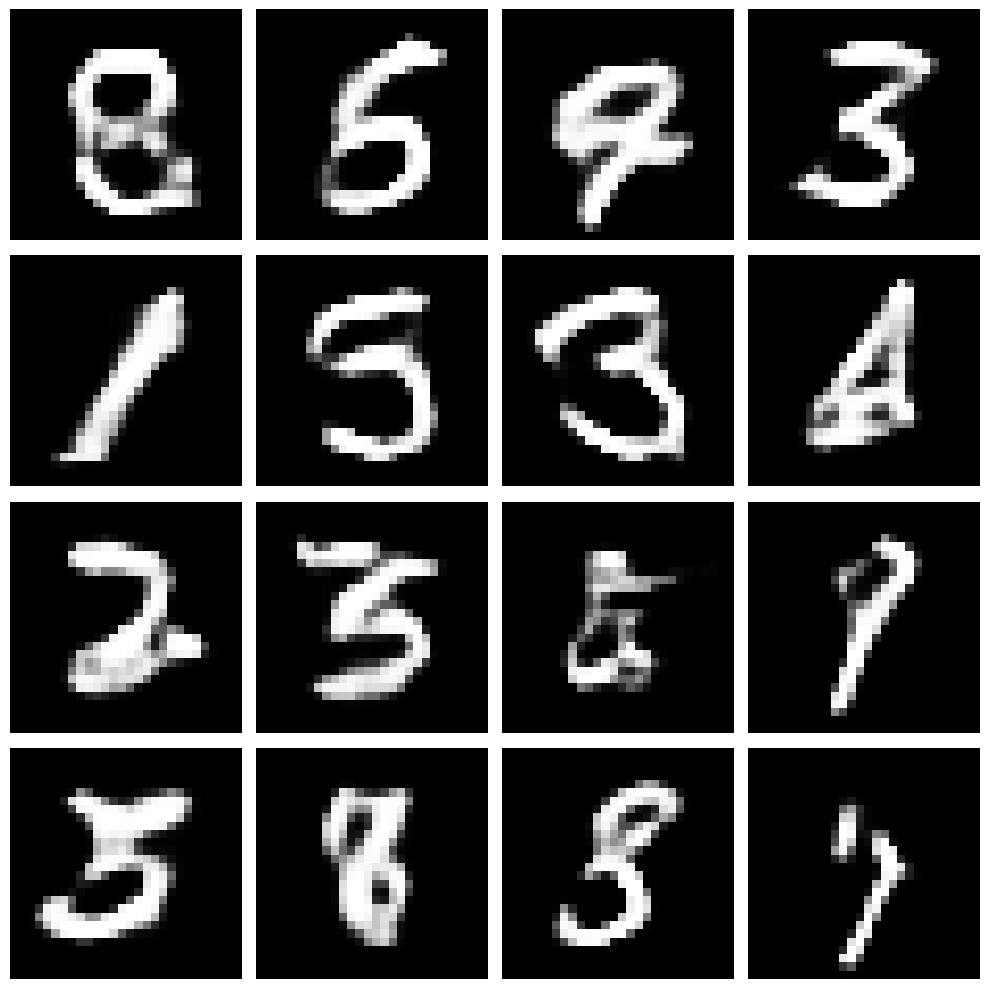

In [12]:
timer = ElapsedTimer()
train(train_epochs=1000, batch_size=256, save_interval=100)
timer.elapsed_time()
plot_images(fake=True)
plot_images(fake=False, saveToFile=True)

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<p><strong>Ejercicio [1 pts.]:</strong>
Contesta a las siguientes preguntas:
</div>

**1. Explica qué hacen las siguientes líneas de código:**

```python
timer = ElapsedTimer()
train(train_epochs=1000, batch_size=256, save_interval=100)
timer.elapsed_time()
plot_images(fake=True)
plot_images(fake=False, saveToFile=True)
```
timer = ElapsedTimer(): Esta línea crea un temporizador que se utiliza para medir el tiempo de entrenamiento del modelo GAN. Podemos observarlo al final de la ejecución que indica: Elapsed: 5.200454084078471 min<br><br>
train(train_epochs=1000, batch_size=256, save_interval=100): Esta línea realiza el entrenamiento del modelo GAN. Especificamos la cantidad de épocas que se ejecutará (1000) y el tamaño de lote (256). El parámetro save_interval indica cada qué invervalo de iteraciones guardamos las imágenes.<br><br>
timer.elapsed_time(): Esta línea devuelve el tiempo transcurrido del timer que hemos creado antes del entrenamiento. Mide la duración total del entrenamiento del modelo GAN.<br><br>
plot_images(fake=True): Esta línea llama a la función que creada anteriormente. Al no especificar el parámetro saveToFile, mostramos por pantalla el resultado. En este caso, mostramos 16 imágenes falsas generadas por el generador a partir de un ruido aleatorio.<br><br>
plot_images(fake=False, saveToFile=True): Esta línea similar a la anterior llama a la función plot_images. En este caso, pasamos el parametro fake=False, por lo que en lugar de generar imágenes, se escogen imágenes reales del conjunto de entrenamiento. Además, se añade el parametro saveToFile, por lo que en lugar de mostrar el resultado en el notebook se guarda en un fichero con el nombre mnist.png

**2. Escribe el código necesario para mostrar las imágenes generadas en la última iteración y muestra los resultados:**

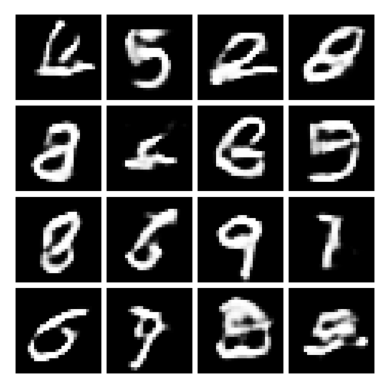

In [16]:
import matplotlib.image as mpimg

# La última iteración es la 1000
image_path = 'images/mnist_1000.png'

# Mostramos la imagen
plt.imshow(mpimg.imread(image_path))
plt.axis('off')
plt.show()

# Referencias consultadas:

* Añadir

https://developers.google.com/machine-learning/gan/gan_structure

https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/experimental/RMSprop

https://deepchecks.com/glossary/rmsprop/#:~:text=RMSprop%20is%20an%20innovative%20stochastic,and%20other%20Machine%20Learning%20techniques

https://datascience.stackexchange.com/questions/26792/difference-between-rmsprop-with-momentum-and-adam-optimizers#:~:text=Adam%20is%20slower%20to%20change,both%20use%20the%20same%20learning_rate)

https://keras.io/api/layers/activation_layers/leaky_relu/